## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import norm

import os
import glob

## Methods

In [2]:
def calculate_correlations_with_significance(difference_df_stylo, difference_df):
    correlation_results = {}
    p_value_symbole_results = {}
    p_value_results = {}

    for feature in difference_df_stylo["Feature"].unique():
        filtered_stylo_df = difference_df_stylo[difference_df_stylo["Feature"] == feature]

        # Calculate Pearson correlation and p-value
        correlation, p_value = pearsonr(filtered_stylo_df["Difference"], difference_df["Difference"])
        correlation_results[feature] = correlation
        p_value_results[feature] = p_value

        # Assign asterisk based on p-value significance
        if p_value < 0.01:
            p_value_symbole_results[feature] = '**'
        elif p_value < 0.05:
            p_value_symbole_results[feature] = '*'
        else:
            p_value_symbole_results[feature] = ''

    correlation_df = pd.DataFrame({
        'Feature': list(correlation_results.keys()),
        'Correlation': list(correlation_results.values()),
        'P-value_symbole': list(p_value_symbole_results.values()),  # Store significance asterisks
        'P-value': list(p_value_results.values()),
    })

    return correlation_df

In [3]:
def fisher_z(r):
  return 0.5 * np.log((1 + r) / (1 - r))

In [4]:
def compare_correlations(r1, n1, r2, n2):
  """
  r1, r2 : Fischer transformed correlations
  n1, n2 : sample size
  """
  z1 = fisher_z(r1)
  z2 = fisher_z(r2)
  se = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
  z = np.abs(z1 - z2) / se
  p = 2 * (1 - norm.cdf(z)) # two-tailed
  return z, p
# Example usage:
# z_score, p_value = compare_correlations(0.65, 96, 0.45, 96)

In [5]:
def tost_compare_correlations_z(r1, n1, r2, n2, delta_z=0.01, alpha=0.05):
    """
    TOST equivalence test for two correlations (in Fisher z-space).

    Returns:
        p1, p2 : one-sided p-values
        equivalent : True if both p-values < alpha
    """
    z1 = fisher_z(r1)
    z2 = fisher_z(r2)
    diff = z1 - z2
    print(f"Difference in z-space: {diff:.3f}")
    se = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))

    z_stat_low = (diff + delta_z) / se
    z_stat_high = (diff - delta_z) / se

    # CORRECTED: Flip these p-values
    p1 = 1 - norm.cdf(z_stat_low)  # test: diff > -delta
    p2 = norm.cdf(z_stat_high)     # test: diff < delta

    equivalent = (p1 < alpha) and (p2 < alpha)
    return p1, p2, equivalent

def r_to_z_delta(delta_r):
    r = 0.0  # center at 0 to be conservative
    r1 = min(max(r - delta_r, -0.9999), 0.9999)
    r2 = min(max(r + delta_r, -0.9999), 0.9999)
    return np.abs(fisher_z(r2) - fisher_z(r1))

## Dataset

### Stylometry

In [68]:
stylo_df = pd.read_excel('./stylo_terreau_df.xlsx')

In [69]:
stylo_df_tuffery_ref_fr = stylo_df[stylo_df['author'] == "Tuffery"]

stylo_df_style_ref_fr = stylo_df[stylo_df['genAI'] == "No"]
stylo_df_style_ref_fr = stylo_df_style_ref_fr[stylo_df_style_ref_fr['author'] != "Tuffery"]

stylo_df_TS_ref_fr = pd.concat([stylo_df_tuffery_ref_fr, stylo_df_style_ref_fr], axis=0)

stylo_df_TS_ref_fr = stylo_df_TS_ref_fr.rename(columns={"id": "file_name", "Unnamed: 0":"id"})

stylo_df_TS_ref_fr["class"] = stylo_df_TS_ref_fr["author"].map({"Tuffery": "A1", "Proust": "B1", "Celine": "B1", "Yourcenar":"B1"})

stylo_df = stylo_df_TS_ref_fr

In [70]:
stylo_df.head()

,id,author,genAI,Punctuation,TAG,Structural,Indexes,NER,Letters,text_id,file_name,class
960,960,Tuffery,No,0.019510,0.195833,8.794737,7.159736,0.083333,0.029505,0,tuffery_agitato_atrabile.txt,A1
961,961,Tuffery,No,0.011617,0.436869,22.038070,7.771713,0.454545,0.029591,1,tuffery_agitato_lamentabile.txt,A1
962,962,Tuffery,No,0.011944,0.407407,18.214147,6.612949,0.222222,0.028414,2,tuffery_anacephaleose.txt,A1
963,963,Tuffery,No,0.011217,0.200617,9.133420,6.714099,0.092593,0.028595,3,tuffery_anadiploses_epanadiploses.txt,A1
964,964,Tuffery,No,0.010989,1.333333,59.190000,5.093733,1.000000,0.031382,4,tuffery_anaphore.txt,A1


In [71]:
#Normalize and compute the mean of features 

numeric_cols = stylo_df.select_dtypes(include=['number']).columns  # Get numeric columns

for col in numeric_cols:
    stylo_df[f"{col}_normalized"] = (stylo_df[col] - stylo_df[col].min()) / (stylo_df[col].max() - stylo_df[col].min())

#Mean
columns_to_average = ["Structural_normalized",
                      "Letters_normalized",
                      "TAG_normalized",
                      "NER_normalized",
                       "Indexes_normalized",
                      ]
stylo_df["Mean"] = stylo_df[columns_to_average].mean(axis=1)

In [75]:
df_subset = stylo_df[["author"] + columns_to_average]

mean_by_author = df_subset.groupby("author").mean(numeric_only=True)

mean_by_author = mean_by_author.T

mean_by_author = mean_by_author.rename_axis("feature", axis="columns")
mean_by_author = mean_by_author[['Tuffery', 'Proust', 'Celine', 'Yourcenar']]
mean_by_author.index = mean_by_author.index.str.replace('_normalized', '', regex=False)
mean_by_author.index = mean_by_author.index.str.replace('Indexes', 'Entropy', regex=False)

mean_by_author.head()

feature,Tuffery,Proust,Celine,Yourcenar
Structural,0.054095,0.154980,0.032130,0.058004
Letters,0.284825,0.251919,0.252227,0.275529
TAG,0.056540,0.143150,0.032347,0.041741
NER,0.044785,0.155766,0.040569,0.070331
Entropy,0.469363,0.524524,0.474654,0.589203


### Distance between embeddings

In [15]:
mean_distances_df = pd.read_excel('./distance_pertext_umap_TS_ref.xlsx')

mean_distances_df["genAI"] = mean_distances_df["Class"].map({"Proust": "No", "Celine": "No", "Yourcenar": "No", "Tuffery": "No",
                                                             "Proust_mistral": "mistral", "Celine_mistral": "mistral", "Yourcenar_mistral": "mistral",
                                                             "Proust_gpt": "gpt", "Celine_gpt": "gpt", "Yourcenar_gpt": "gpt",
                                                             "Proust_gemini": "gemini", "Celine_gemini": "gemini", "Yourcenar_gemini": "gemini",
                                                             })

mean_distances_df["author"] = mean_distances_df["Class"].map({"Proust": "Proust", "Celine": "Celine", "Yourcenar": "Yourcenar","Tuffery": "Tuffery",
                                                             "Proust_mistral": "Proust", "Celine_mistral": "Celine", "Yourcenar_mistral": "Yourcenar",
                                                             "Proust_gpt": "Proust", "Celine_gpt": "Celine", "Yourcenar_gpt": "Yourcenar",
                                                             "Proust_gemini": "Proust", "Celine_gemini": "Celine", "Yourcenar_gemini": "Yourcenar",
                                                             })

mean_distances_df["class"] = mean_distances_df["author"].map({"Tuffery": "A1", "Proust": "B1", "Celine": "B1", "Yourcenar":"B1"})
mean_distances_df = mean_distances_df.drop(columns=["Class"])

In [16]:
mean_distances_df.head()

,Text_Index,Mean_Distance_From_Centroid,genAI,author,class
0,0,1.493536,No,Tuffery,A1
1,1,3.086941,No,Tuffery,A1
2,2,1.641952,No,Tuffery,A1
3,3,1.457144,No,Tuffery,A1
4,4,1.759076,No,Tuffery,A1


## Toutes features confondues, all authors : correlation, p-value

In [18]:
#### DISPERSION DELTA ANALYSIS FOR 2 COMPARISONS


## Humans vs genAI

# Dispersion delta
Tuffery_distances = mean_distances_df[mean_distances_df['author'] == 'Tuffery']['Mean_Distance_From_Centroid'].values
Authors_distances = mean_distances_df[mean_distances_df['author'] != 'Tuffery']['Mean_Distance_From_Centroid'].values

# List to store the results
difference_results = []

for i, ref_dist in enumerate(Tuffery_distances):
    for j, gen_dist in enumerate(Authors_distances):
        difference = ref_dist - gen_dist
        difference_results.append({
            'Tuffery_Index': i,
            'Authors_Index': j,
            'Difference': difference
        })

difference_df_cond1 = pd.DataFrame(difference_results)



In [19]:
# Style delta calculation

Tuffery_df = stylo_df[stylo_df['author'] == 'Tuffery']
Authors_df = stylo_df[stylo_df['author'] != 'Tuffery']

# List of stylistic features
# features = ['Function words', 'Letters', 'Numbers', 'TAG', 'NER', 'Structural', 'Punctuation', 'Indexes']
features = ['Mean']

# Initialize a list to store the results
difference_results_stylo = []

for feature in features:
    for i, ref_val in enumerate(Tuffery_df[feature].values):
        for j, gen_val in enumerate(Authors_df[feature].values):
            difference = ref_val - gen_val
            difference_results_stylo.append({
                'Feature': feature,
                'Tuffery_Index': i,
                'Authors_Index': j,
                'Difference': difference
            })

difference_df_stylo_cond1 = pd.DataFrame(difference_results_stylo)

In [20]:
correlation_df_cond1 = calculate_correlations_with_significance(difference_df_stylo_cond1, difference_df_cond1)

# correlation_df_cond1 = correlation_df_cond1.sort_values(by='Correlation_proust', ascending=False)
print(correlation_df_cond1.to_string())
print(correlation_df_cond1["Correlation"])

  Feature  Correlation P-value_symbole       P-value
0    Mean     0.057384              **  1.307735e-21
0    0.057384
Name: Correlation, dtype: float64


## Toutes features confondues, per author : correlation, p-value

In [21]:
#### DISPERSION DELTA ANALYSIS FOR 2 COMPARISONS


## Humans vs genAI

# Dispersion delta
Tuffery_distances = mean_distances_df[mean_distances_df['author'] == 'Tuffery']['Mean_Distance_From_Centroid'].values

GenAI_distances = {}
difference_df_cond1 = {}

for auteur in ["Proust", "Celine", "Yourcenar"]:
    GenAI_distances[auteur] = mean_distances_df[mean_distances_df['author'] == auteur]['Mean_Distance_From_Centroid'].values
    # List to store the results
    difference_results = []

    for i, ref_dist in enumerate(Tuffery_distances):
        for j, gen_dist in enumerate(GenAI_distances[auteur]):
            difference = ref_dist - gen_dist
            difference_results.append({
                'Tuffery_Index': i,
                f'{auteur}_Index': j,
                'Difference': difference
            })

    difference_df_cond1[auteur] = pd.DataFrame(difference_results)



In [22]:
# Style delta calculation

Tuffery_df = stylo_df[stylo_df['author'] == 'Tuffery']

GenAI_stylo = {}
difference_df_stylo_cond1 = {}

# List of stylistic features
# features = ['Function words', 'Letters', 'Numbers', 'TAG', 'NER', 'Structural', 'Punctuation', 'Indexes']
features = ['Mean']

for auteur in ["Celine", "Proust", "Yourcenar"]:
    GenAI_stylo[auteur] = stylo_df[stylo_df['author'] == auteur]

    # List to store the results
    difference_results_stylo = []

    for feature in features:
        for i, ref_val in enumerate(Tuffery_df[feature].values):
            for j, gen_val in enumerate(GenAI_stylo[auteur][feature].values):
                difference = ref_val - gen_val
                difference_results_stylo.append({
                    'Feature': feature,
                    'Mistral_Index': i,
                    f'{auteur}_Index': j,
                    'Difference': difference
                })
    difference_df_stylo_cond1[auteur] = pd.DataFrame(difference_results_stylo)


In [23]:
for auteur in ["Celine", "Proust", "Yourcenar"]:

    correlation_df_cond1 = calculate_correlations_with_significance(difference_df_stylo_cond1[auteur], difference_df_cond1[auteur])

    print(f"{auteur}")
    print(correlation_df_cond1.to_string())

Celine
  Feature  Correlation P-value_symbole       P-value
0    Mean     0.159404              **  1.656137e-53
Proust
  Feature  Correlation P-value_symbole       P-value
0    Mean     0.186075              **  1.399222e-72
Yourcenar
  Feature  Correlation P-value_symbole       P-value
0    Mean     0.086404              **  9.637181e-17


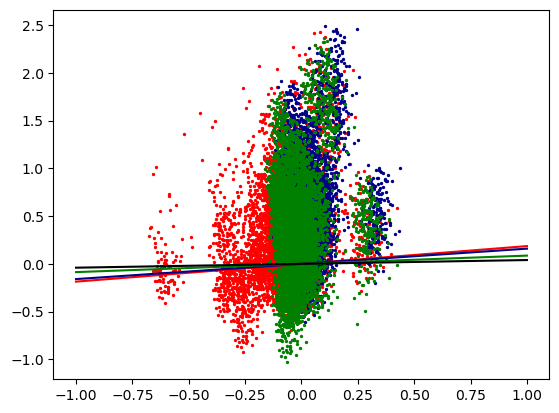

In [24]:
plt.figure()
i = 0
colors = ['red', 'darkblue', 'green']

for auteur in ['Proust', 'Celine', 'Yourcenar']:
    plt.scatter(difference_df_stylo_cond1[auteur]["Difference"], difference_df_cond1[auteur]["Difference"], s=2, c=colors[i])
    correlation_df_cond1 = calculate_correlations_with_significance(difference_df_stylo_cond1[auteur], difference_df_cond1[auteur])

    plt.plot(np.linspace(-1, 1), np.linspace(-1, 1)*correlation_df_cond1["Correlation"].values, c=colors[i])
    i += 1

plt.plot(np.linspace(-1, 1), np.linspace(-1, 1)*0.04, c="black")

# plt.ylim(-1, 1)
plt.show()

In [25]:
difference_df_stylo_cond1

{'Celine':      Feature  Mistral_Index  Celine_Index  Difference
 0       Mean              0             0    0.002179
 1       Mean              0             1   -0.043068
 2       Mean              0             2    0.005371
 3       Mean              0             3    0.022765
 4       Mean              0             4   -0.001765
 ...      ...            ...           ...         ...
 9211    Mean             95            91   -0.020697
 9212    Mean             95            92    0.040760
 9213    Mean             95            93   -0.031354
 9214    Mean             95            94   -0.004503
 9215    Mean             95            95    0.009245
 
 [9216 rows x 4 columns],
 'Proust':      Feature  Mistral_Index  Proust_Index  Difference
 0       Mean              0             0   -0.001799
 1       Mean              0             1    0.014087
 2       Mean              0             2   -0.238098
 3       Mean              0             3   -0.064856
 4       Mean    

## t test sur les features direct

In [26]:
## Testing if the correlations are significatively different
##correlation_proust = calculate_correlations_with_significance(difference_df_stylo_cond1["Proust"], difference_df_cond1["Proust"])['Correlation'].values[0]
#correlation_celine = calculate_correlations_with_significance(difference_df_stylo_cond1["Celine"], difference_df_cond1["Celine"])['Correlation'].values[0]
#correlation_yourcenar = calculate_correlations_with_significance(difference_df_stylo_cond1["Yourcenar"], difference_df_cond1["Yourcenar"])['Correlation'].values[0]

for author_1 in ["Tuffery", "Proust",  "Celine", "Yourcenar"]:
  for author_2 in ["Tuffery",  "Proust", "Celine",  "Yourcenar"]:
    if author_1 != author_2:
      print(f"Entre {author_1} et {author_2} : ")

      for row in correlation_df_cond1.iterrows():
        feature = row[1]['Feature']
  #z_score, p_value = compare_correlations(correlation_proust, 96 , correlation_celine, 96 )
        t_stat, p_value = stats.ttest_ind(stylo_df[stylo_df["author"]==author_1]["Mean"], stylo_df[stylo_df["author"]==author_2]["Mean"], equal_var=False)

        if len(feature) > 4:
          print(f"{feature} \t t = {t_stat:.4f} \t p = {p_value:.6f}")
        else:
          print(f"{feature} \t \t t = {t_stat:.4f} \t p = {p_value:.2e}")

Entre Tuffery et Proust : 


NameError: name 'stats' is not defined

In [27]:
## Testing if the correlations are significatively different
##correlation_proust = calculate_correlations_with_significance(difference_df_stylo_cond1["Proust"], difference_df_cond1["Proust"])['Correlation'].values[0]
#correlation_celine = calculate_correlations_with_significance(difference_df_stylo_cond1["Celine"], difference_df_cond1["Celine"])['Correlation'].values[0]
#correlation_yourcenar = calculate_correlations_with_significance(difference_df_stylo_cond1["Yourcenar"], difference_df_cond1["Yourcenar"])['Correlation'].values[0]

for author_1 in ["Tuffery", "Proust",  "Celine", "Yourcenar"]:
  for author_2 in ["Proust", "Celine",  "Yourcenar"]:
    if author_1 != author_2:
      print(f"Entre {author_1} et {author_2} :")
      for feature in ["TAG", "NER", "Letters", "Structural", "Indexes"]:


        for row in correlation_df_cond1.iterrows():

  #z_score, p_value = compare_correlations(correlation_proust, 96 , correlation_celine, 96 )
          t_stat, p_value = stats.ttest_ind(stylo_df[stylo_df["author"]==author_1][feature], stylo_df[stylo_df["author"]==author_2][feature], equal_var=False)

          if len(feature) > 4:
            print(f"\t {feature} \t t = {t_stat:.4f} \t p = {p_value:.2e}")
          else:
            print(f"\t {feature} \t \t t = {t_stat:.4f} \t p = {p_value:.2e}")

Entre Tuffery et Proust :


NameError: name 'stats' is not defined

## Per feature, per author : correlation, p-value

In [208]:
#### DISPERSION DELTA ANALYSIS FOR 2 COMPARISONS


## Humans vs genAI

# Dispersion delta
Tuffery_distances = mean_distances_df[mean_distances_df['author'] == 'Tuffery']['Mean_Distance_From_Centroid'].values

GenAI_distances = {}
difference_df_cond1 = {}


for auteur in ["Proust", "Celine", "Yourcenar"]:
    GenAI_distances[auteur] = mean_distances_df[mean_distances_df['author'] == auteur]['Mean_Distance_From_Centroid'].values

    # List to store the results
    difference_results = []

    for i, ref_dist in enumerate(Tuffery_distances):
        for j, gen_dist in enumerate(GenAI_distances[auteur]):
            difference = ref_dist - gen_dist
            difference_results.append({
                'Tuffery_Index': i,
                f'{auteur}_Index': j,
                'Difference': difference
            })

    difference_df_cond1[auteur] = pd.DataFrame(difference_results)



In [209]:
# Style delta calculation

Tuffery_df = stylo_df[stylo_df['author'] == 'Tuffery']

GenAI_stylo = {}
difference_df_stylo_cond1 = {}

# List of stylistic features
#features = ['Function words', 'Letters', 'Numbers', 'TAG', 'NER', 'Structural', 'Punctuation', 'Indexes']
features = ['Letters', 'TAG', 'NER', 'Structural', 'Indexes']
# features = ['Mean']

for auteur in ["Proust", "Celine", "Yourcenar"]:
    GenAI_stylo[auteur] = stylo_df[stylo_df['author'] == auteur]

    # List to store the results
    difference_results_stylo = []

    for feature in features:
        for i, ref_val in enumerate(Tuffery_df[feature].values):
            for j, gen_val in enumerate(GenAI_stylo[auteur][feature].values):
                difference = ref_val - gen_val
                difference_results_stylo.append({
                    'Feature': feature,
                    'Mistral_Index': i,
                    f'{auteur}_Index': j,
                    'Difference': difference
                })
    difference_df_stylo_cond1[auteur] = pd.DataFrame(difference_results_stylo)

In [210]:
for auteur in ["Proust", "Celine", "Yourcenar"]:

    correlation_df_cond1 = calculate_correlations_with_significance(difference_df_stylo_cond1[auteur], difference_df_cond1[auteur])

    print(f"{auteur}")
    print(correlation_df_cond1.to_string())

Proust
      Feature  Correlation P-value_symbole       P-value
0     Letters     0.162653              **  1.149980e-55
1         TAG     0.127352              **  1.246612e-34
2         NER     0.195370              **  5.789288e-80
3  Structural     0.135972              **  2.793552e-39
4     Indexes     0.013114                  2.081026e-01
Celine
      Feature  Correlation P-value_symbole       P-value
0     Letters     0.161415              **  7.736992e-55
1         TAG     0.004683                  6.530689e-01
2         NER     0.132148              **  3.528125e-37
3  Structural     0.011195                  2.825510e-01
4     Indexes     0.104475              **  8.666099e-24
Yourcenar
      Feature  Correlation P-value_symbole       P-value
0     Letters     0.055860              **  8.049916e-08
1         TAG    -0.004307                  6.793163e-01
2         NER     0.212397              **  1.703754e-94
3  Structural    -0.004648                  6.554719e-01
4     I

### To latex

In [211]:
Proust = calculate_correlations_with_significance(difference_df_stylo_cond1['Proust'], difference_df_cond1['Proust'])
Celine = calculate_correlations_with_significance(difference_df_stylo_cond1['Celine'], difference_df_cond1['Celine'])
Yourcenar = calculate_correlations_with_significance(difference_df_stylo_cond1['Yourcenar'], difference_df_cond1['Yourcenar'])



# Standard list of features (in desired order)
features = ['Letters', 'TAG', 'NER', 'Structural']

# Ensure each dataframe is indexed by 'Feature' for easy lookup
Proust.set_index('Feature', inplace=True)
Celine.set_index('Feature', inplace=True)
Yourcenar.set_index('Feature', inplace=True)

# Start LaTeX table
latex = []
latex.append(r" & \multicolumn{2}{|c|}{Proust} & \multicolumn{2}{|c|}{Celine} & \multicolumn{2}{|c|}{Yourcenar} \\")
latex.append(r"\hline")
latex.append(r"Feature & Correlation & P-value & Correlation & P-value & Correlation & P-value  \\")
latex.append(r"\hline")

# Populate rows
for feature in features:
    row = [feature]
    for df in [Proust, Celine, Yourcenar]:
        corr = df.loc[feature, 'Correlation'] if feature in df.index else ''
        pval = df.loc[feature, 'P-value'] if feature in df.index else ''
        psymb= df.loc[feature, 'P-value_symbole'] if feature in df.index else ''
        row.extend([f"{corr:.4f}", f"{pval:.1e} ({psymb})"])
    latex.append(" & ".join(row) + r" \\")  # row end
latex.append(r"\hline")

# Join and print LaTeX code
latex_table = "\n".join(latex)
print(latex_table)

 & \multicolumn{2}{|c|}{Proust} & \multicolumn{2}{|c|}{Celine} & \multicolumn{2}{|c|}{Yourcenar} \\
\hline
Feature & Correlation & P-value & Correlation & P-value & Correlation & P-value  \\
\hline
Letters & 0.1627 & 1.1e-55 (**) & 0.1614 & 7.7e-55 (**) & 0.0559 & 8.0e-08 (**) \\
TAG & 0.1274 & 1.2e-34 (**) & 0.0047 & 6.5e-01 () & -0.0043 & 6.8e-01 () \\
NER & 0.1954 & 5.8e-80 (**) & 0.1321 & 3.5e-37 (**) & 0.2124 & 1.7e-94 (**) \\
Structural & 0.1360 & 2.8e-39 (**) & 0.0112 & 2.8e-01 () & -0.0046 & 6.6e-01 () \\
\hline


## Plot

In [212]:
# print(stylo_df.head())
grouped = stylo_df.groupby('author')[['Structural_normalized', 'Letters_normalized', 'TAG_normalized', 'NER_normalized', 'Indexes_normalized']].mean()
print(grouped)

           Structural_normalized  Letters_normalized  TAG_normalized  \
author                                                                 
Celine                  0.032130            0.252227        0.032347   
Proust                  0.154980            0.251919        0.143150   
Tuffery                 0.054095            0.284825        0.056540   
Yourcenar               0.058004            0.275529        0.041741   

           NER_normalized  Indexes_normalized  
author                                         
Celine           0.040569            0.474654  
Proust           0.155766            0.524524  
Tuffery          0.044785            0.469363  
Yourcenar        0.070331            0.589203  


In [213]:
features = ['Structural_normalized', 'Letters_normalized',
            'TAG_normalized', 'NER_normalized', 'Indexes_normalized']

# Melt into long format
m = stylo_df.melt(
    id_vars='author',
    value_vars=features,
    var_name='feature',
    value_name='value'
)

# Compute the pooled mean per author across all features
overall_mean = m.groupby('author')['value'].mean()

print(overall_mean)


author
Celine       0.166385
Proust       0.246068
Tuffery      0.181922
Yourcenar    0.206961
Name: value, dtype: float64


In [214]:
import pandas as pd
from scipy import stats
from itertools import combinations

features = ['Structural_normalized', 'Letters_normalized', 'TAG_normalized', 'NER_normalized', 'Indexes_normalized']

long_df = stylo_df.melt(
    id_vars='author',
    value_vars=features,
    var_name='feature',
    value_name='value'
)

In [215]:
np.mean([0.058004, 0.275529, 0.041741, 0.070331, 0.589203])

np.float64(0.2069616)

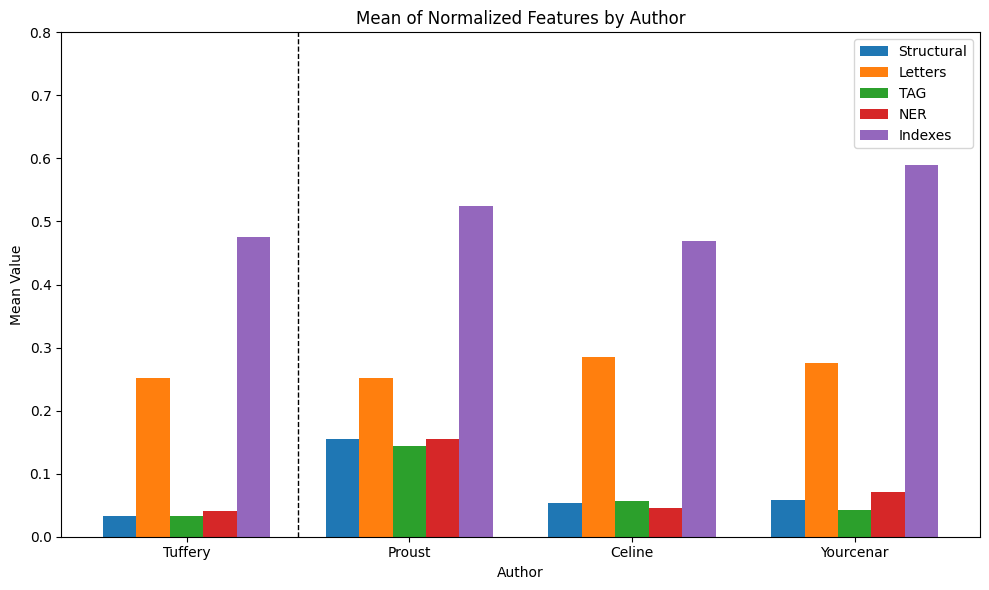

In [ ]:
authors = ['Tuffery', 'Proust', 'Celine', 'Yourcenar']
columns = grouped.columns.tolist()
x = np.arange(len(authors))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

for i, col in enumerate(columns):
    ax.bar(x + i * width, grouped[col], width, label=col[:-11])

ax.set_xlabel('Author')
ax.set_ylabel('Mean Value')
ax.set_title('Mean of Normalized Features by Author')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(authors)
ax.set_ylim(-0.0, 0.8)
ax.legend()

plt.tight_layout()

ax.axvline(x=0.5 + width * 2, color='black', linestyle='--', linewidth=1)


plt.show()